<a href="https://colab.research.google.com/github/flexycode/CCMACLRL_EXERCISES_COM231ML/blob/main/Lab/Lab-Exercise-4/Exercise4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 4: Hate Speech Classification using Multinomial Naive Bayes

Instructions:
- You do not need to split your data. Use the training, validation and test sets provided below.
- Use Multinomial Naive Bayes to train a model that can classify if a sentence is a hate speech or non-hate speech
- A sentence with a label of zero (0) is classified as non-hate speech
- A sentence with a label of one (1) is classified as a hate speech

Apply text pre-processing techniques such as
- Converting to lowercase
- Stop word Removal
- Removal of digits, special characters
- Stemming or Lemmatization but not both
- Count Vectorizer or TF-IDF Vectorizer but not both

Evaluate your model by:
- Providing input by yourself
- Creating a Confusion Matrix
- Calculating the Accuracy, Precision, Recall and F1-Score

In [84]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

# ML libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Set style for visualizations
plt.style.use('default')
sns.set_palette("husl")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [110]:
splits = {'train': 'unique_train_dataset.csv', 'validation': 'unique_validation_dataset.csv', 'test': 'unique_test_dataset.csv'}

df_train = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["train"])
df_validation = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["validation"])
df_test = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["test"])

**Training Set**

Use this to train your model

In [111]:
df_train = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["train"])

**Validation Set**

Use this set to evaluate your model

In [112]:
df_validation = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["validation"])

**Test Set**
  
Use this set to test your model

In [113]:
df_test = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["test"])

## A. Understanding your training data

1. Check the first 10 rows of the training dataset

In [90]:
print("First 10 rows of training dataset:")
display(df_train.head(10))

First 10 rows of training dataset:


,text,label
0,Presidential candidate Mar Roxas implies that ...,1
1,Parang may mali na sumunod ang patalastas ng N...,1
2,Bet ko. Pula Ang Kulay Ng Posas,1
3,[USERNAME] kakampink,0
4,Bakit parang tahimik ang mga PINK about Doc Wi...,1
5,"""Ang sinungaling sa umpisa ay sinungaling hang...",1
6,Leni Kiko,0
7,Nahiya si Binay sa Makati kaya dito na lang sa...,1
8,Another reminderHalalan,0
9,[USERNAME] Maybe because VP Leni Sen Kiko and ...,0


2. Check how many rows and columns are in the training dataset using `.info()`

In [91]:
print("\nDataset info:")
df_train.info()


Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21773 entries, 0 to 21772
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    21773 non-null  object
 1   label   21773 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 340.3+ KB


3. Check for NaN values

In [92]:
print(f"\nNaN values in training set: {df_train.isnull().sum().sum()}")


NaN values in training set: 0


4. Check for duplicate rows

In [93]:
print(f"Duplicate rows in training set: {df_train.duplicated().sum()}")

Duplicate rows in training set: 0


5. Check how many rows belong to each class

In [94]:
class_distribution = df_train['label'].value_counts()
print(f"\nClass distribution:\n{class_distribution}")


Class distribution:
label
1    10994
0    10779
Name: count, dtype: int64


## Bar Chart

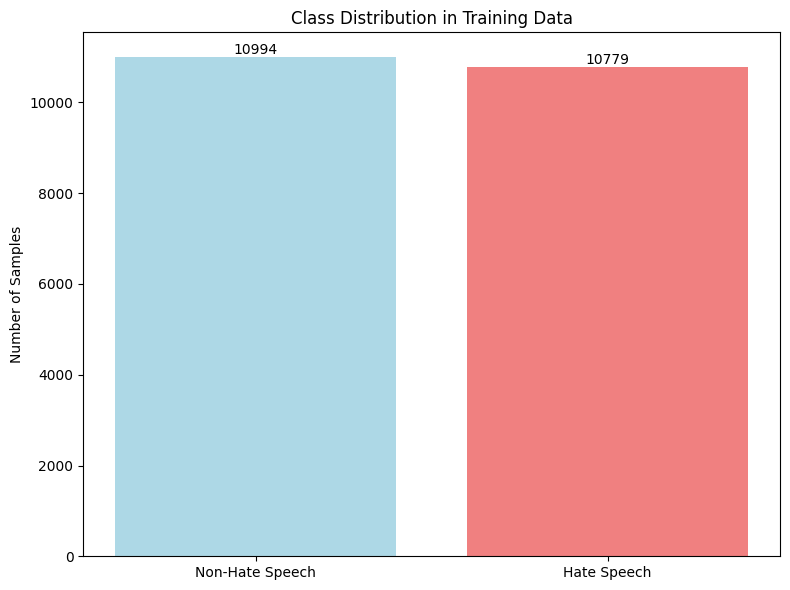

In [118]:
plt.figure(figsize=(8, 6))
bars = plt.bar(['Non-Hate Speech', 'Hate Speech'], class_distribution.values,
               color=['lightblue', 'lightcoral'])
plt.title('Class Distribution in Training Data')
plt.ylabel('Number of Samples')

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 10,
             f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## Pie Chart

In [115]:
fig = px.pie(values=class_distribution.values,
             names=['Non-Hate Speech', 'Hate Speech'],
             title='Class Distribution in Training Data',
             color_discrete_sequence=px.colors.sequential.RdBu)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

## B. Text pre-processing

## Initialize stemmer and stopwords

6. Remove duplicate rows

In [131]:
initial_count = len(df_train)
df_train = df_train.drop_duplicates(subset='cleaned_text')
final_count = len(df_train)
print(f"Removed {initial_count - final_count} duplicate rows from training set")

KeyError: Index(['cleaned_text'], dtype='object')

7. Remove rows with NaN values

In [129]:
initial_count = len(df_train)
df_train = df_train.dropna(subset=['cleaned_text'])
final_count = len(df_train)
print(f"Removed {initial_count - final_count} rows with NaN values from training set")

print("Text preprocessing completed!")

KeyError: ['cleaned_text']

8. Convert all text to lowercase

In [134]:
df_train['text'] = df_train['text'].str.lower()
df_validation['text'] = df_validation['text'].str.lower()
df_test['text'] = df_test['text'].str.lower()

df_train["text"].head()

,text
0,presidential candidate mar roxas implies that ...
1,parang may mali na sumunod ang patalastas ng n...
2,bet ko. pula ang kulay ng posas
3,[username] kakampink
4,bakit parang tahimik ang mga pink about doc wi...


9. Remove digits, URLS and special characters

In [135]:
def text_clean(text):
    text = re.sub(r"\n","",text)                          # Remove line breaks
    text = text.lower()                                   # Convert to lowercase
    text = re.sub(r"\d+","",text)                         # Remove digits and currencies
    text = re.sub(r'[$\d+\d+$]', "", text)                #
    text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)   # Remove dates
    text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)
    text = re.sub(r'\d+[\.\/-]\d+[\.\/-]\d+', '', text)
    text = re.sub(r'[^\x00-\x7f]',r' ',text)              # Remove non-ascii
    text = re.sub(r'[^\w\s]','',text)                     # Remove punctuation (replace with space)
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)      # Remove URLs
    return text

df_train['text'] = df_train['text'].apply(lambda x: text_clean(x))
df_validation['text'] = df_validation['text'].apply(lambda x: text_clean(x))
df_test['text'] = df_test['text'].apply(lambda x: text_clean(x))


In [136]:
df_train['text'].head()

,text
0,presidential candidate mar roxas implies that ...
1,parang may mali na sumunod ang patalastas ng n...
2,bet ko pula ang kulay ng posas
3,username kakampink
4,bakit parang tahimik ang mga pink about doc wi...


10. Remove stop words

In [138]:
def preprocess_text(text):
  tokens = text.split()
  tokens = [word for word in tokens if word not in stop_words]  # remove stopwords
  tokens = [stemmer.stem(word) for word in tokens]              # stemming
  return " ".join(tokens)

11. Use Stemming or Lemmatization

In [139]:
df_train['text'] = df_train['text'].apply(preprocess_text)
df_validation['text'] = df_validation['text'].apply(preprocess_text)
df_test['text'] = df_test['text'].apply(preprocess_text)

## C. Training your model

12. Put all text training data in variable **X_train**

In [142]:
X_train = df_train["text"]

13. Put all training data labels in variable **y_train**

In [143]:
y_train = df_train['label']

14. Use `CountVectorizer()` or `TfidfVectorizer()` to convert text data to its numerical form.

Put the converted data to **X_train_transformed** variable

In [144]:
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_transformed = vectorizer.fit_transform(X_train)

print(f"Vocabulary size: {len(vectorizer.get_feature_names_out())}")

Vocabulary size: 5000


15. Create an instance of `MultinomalNB()`

In [146]:
model = MultinomialNB()

# Hyperparameter tuning using GridSearchCV
param_grid = {'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_transformed, y_train)

# Get the best model
best_alpha = grid_search.best_params_['alpha']
print(f"Best alpha parameter: {best_alpha}")

Best alpha parameter: 0.1


16. Train the model using `.fit()`

In [147]:
model = MultinomialNB(alpha=best_alpha)
model.fit(X_train_transformed, y_train)
print("Model training completed!")

Model training completed!


## D. Evaluate your model

17. Use `.predict()` to generate model predictions using the **validation dataset**


- Put all text validation data in **X_validation** variable

- Convert **X_validation** to its numerical form.

- Put the converted data to **X_validation_transformed**

- Put all predictions in **y_validation_pred** variable

In [152]:
X_validation = df_validation["text"]

X_validation_transformed = vectorizer.transform(X_validation)

y_validation_pred = model.predict(X_validation_transformed)

18. Get the Accuracy, Precision, Recall and F1-Score of the model using the **validation dataset**

- Put all validation data labels in **y_validation** variable

In [153]:
accuracy_val = accuracy_score(y_validation, y_validation_pred)
precision_val = precision_score(y_validation, y_validation_pred)
recall_val = recall_score(y_validation, y_validation_pred)
f1_val = f1_score(y_validation, y_validation_pred)

print("Validation Set Performance:")
print(f"Accuracy: {accuracy_val:.4f}")
print(f"Precision: {precision_val:.4f}")
print(f"Recall: {recall_val:.4f}")
print(f"F1-Score: {f1_val:.4f}")

Validation Set Performance:
Accuracy: 0.8268
Precision: 0.8096
Recall: 0.8594
F1-Score: 0.8337


19. Create a confusion matrix using the **validation dataset**

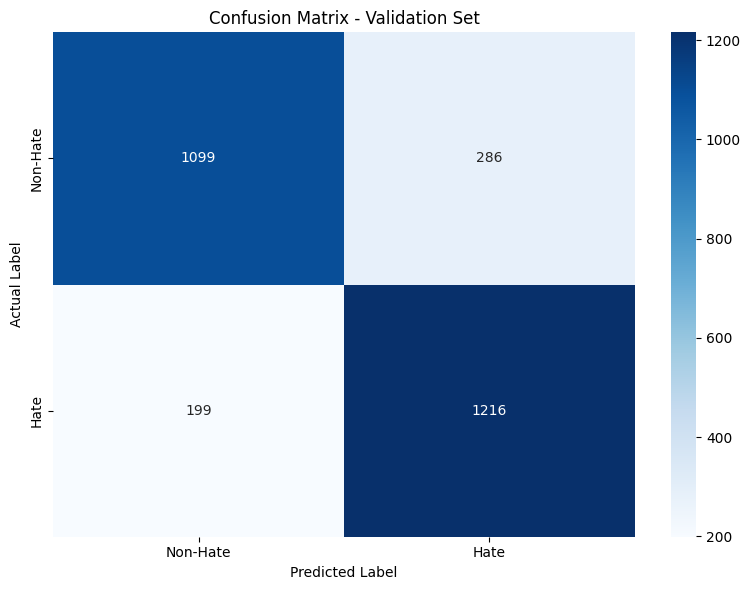

In [157]:
cm_val = confusion_matrix(y_validation, y_validation_pred)

# Create a heatmap for confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Hate', 'Hate'],
            yticklabels=['Non-Hate', 'Hate'])
plt.title('Confusion Matrix - Validation Set')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

20. Use `.predict()` to generate the model predictions using the **test dataset**


- Put all text validation data in **X_test** variable

- Convert **X_test** to its numerical form.

- Put the converted data to **X_test_transformed**

- Put all predictions in **y_test_pred** variable

In [159]:
X_test = df_test["text"]

X_test_transformed = vectorizer.transform(X_test)

y_test_pred = model.predict(X_test_transformed)

21. Get the Accuracy, Precision, Recall and F1-Score of the model using the **test dataset**

- Put all test data labels in **y_validation** variable



In [161]:
y_test = df_test["label"]

accuracy_test = accuracy_score(y_test, y_test_pred)
precision_test = precision_score(y_test, y_test_pred)
recall_test = recall_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred)

print("\nTest Set Performance:")
print(f"Accuracy: {accuracy_test:.4f}")
print(f"Precision: {precision_test:.4f}")
print(f"Recall: {recall_test:.4f}")
print(f"F1-Score: {f1_test:.4f}")


Test Set Performance:
Accuracy: 0.8320
Precision: 0.8018
Recall: 0.8798
F1-Score: 0.8390


22. Create a confusion matrix using the **test dataset**

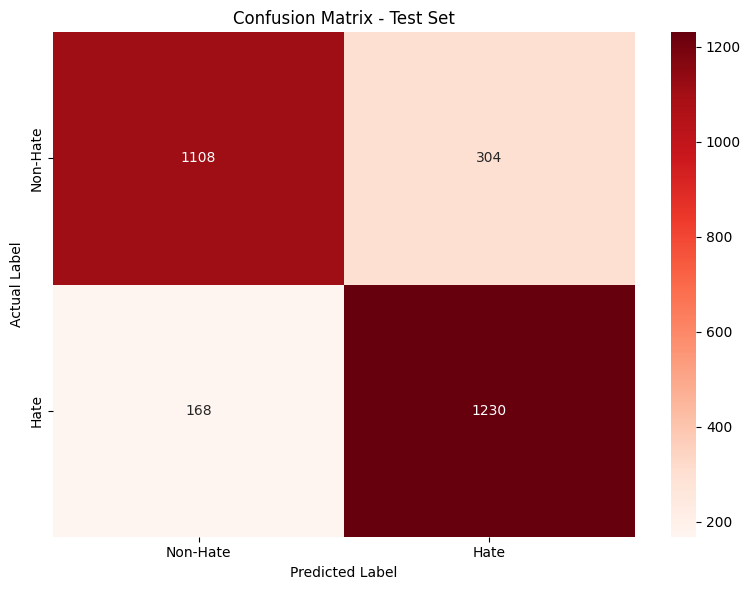

In [162]:
cm_test = confusion_matrix(y_test, y_test_pred)

# Create a heatmap for confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Non-Hate', 'Hate'],
            yticklabels=['Non-Hate', 'Hate'])
plt.title('Confusion Matrix - Test Set')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

## 📊 Comprehensive Performance comparison visualization

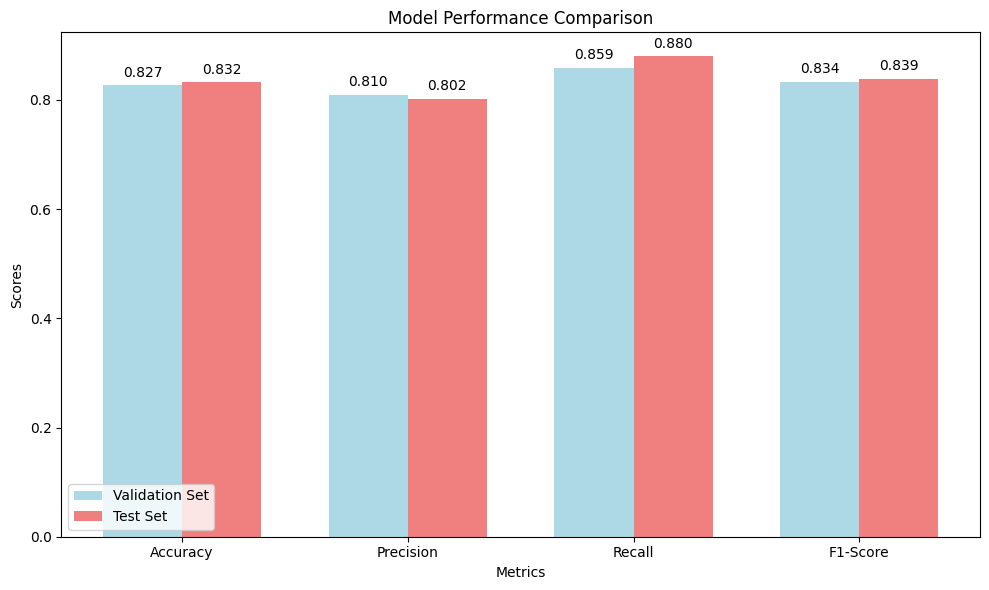

In [163]:
# Create a comprehensive performance comparison visualization
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
validation_scores = [accuracy_val, precision_val, recall_val, f1_val]
test_scores = [accuracy_test, precision_test, recall_test, f1_test]

x = np.arange(len(metrics))
width = 0.35

plt.figure(figsize=(10, 6))
bars1 = plt.bar(x - width/2, validation_scores, width, label='Validation Set', color='lightblue')
bars2 = plt.bar(x + width/2, test_scores, width, label='Test Set', color='lightcoral')

plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.title('Model Performance Comparison')
plt.xticks(x, metrics)
plt.legend()

# Add value labels on top of bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{height:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## E. Test the model

## 💎 Prediction for custom input test model

Non-Hate Speech Example:
Text: I love how diverse our community is and how everyone supports each other.
Cleaned: i love divers commun everyon support other.
Prediction: 0 (Non-Hate Speech) (Confidence: 77.77%)


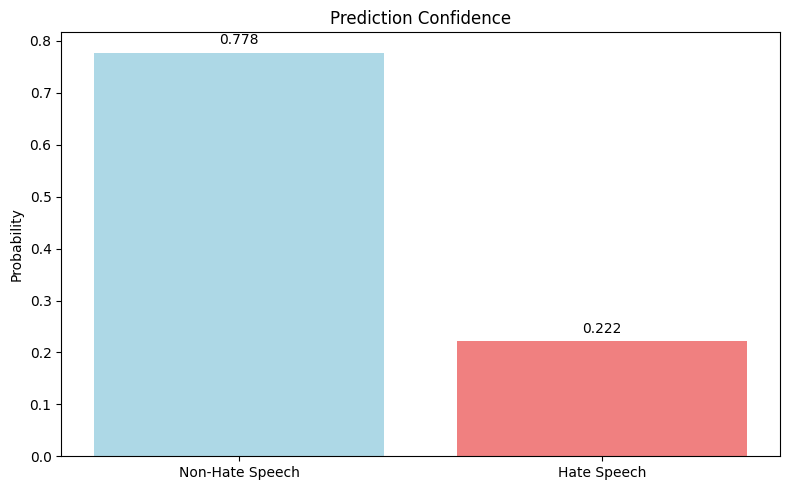


Hate Speech Example:
Text: People like you are the reason this country is going downhill.
Cleaned: peopl like reason countri go downhill.
Prediction: 0 (Non-Hate Speech) (Confidence: 65.11%)


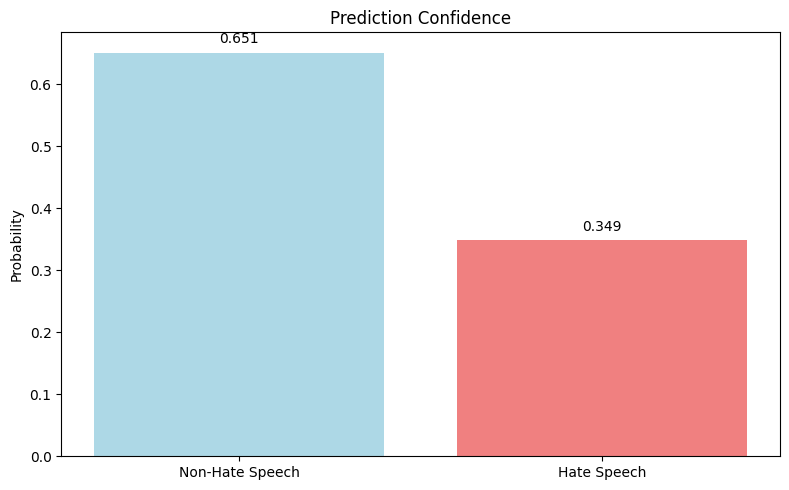

np.int64(0)

In [179]:
# Function to predict custom input with clear 0/1 output
def predict_text(text):
    cleaned_text = preprocess_text(text)
    transformed_text = vectorizer.transform([cleaned_text])
    prediction = model.predict(transformed_text)
    probability = model.predict_proba(transformed_text)

    result = "Hate Speech" if prediction[0] == 1 else "Non-Hate Speech"
    confidence = probability[0][prediction[0]]

    print(f"Text: {text}")
    print(f"Cleaned: {cleaned_text}")
    print(f"Prediction: {prediction[0]} ({result}) (Confidence: {confidence:.2%})")

    # Create a confidence visualization
    plt.figure(figsize=(8, 5))
    bars = plt.bar(['Non-Hate Speech', 'Hate Speech'], probability[0],
                   color=['lightblue', 'lightcoral'])
    plt.title('Prediction Confidence')
    plt.ylabel('Probability')

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{height:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    return prediction[0]

# Sample Test the model with non-hate speech
non_hate_example = "I love how diverse our community is and how everyone supports each other."
print("Non-Hate Speech Example:")
predict_text(non_hate_example)

# Sample Test the model with hate speech
hate_example = "People like you are the reason this country is going downhill."
print("\nHate Speech Example:")
predict_text(hate_example)

22. Create a confusion matrix using the **test dataset**

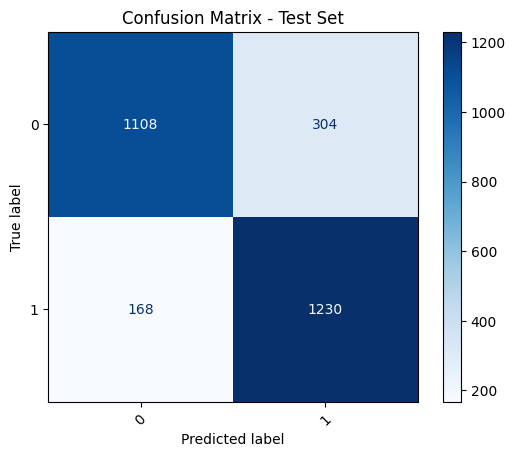

In [175]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)

plt.title("Confusion Matrix - Test Set")
plt.show()


23. Test the model by providing a non-hate speech input. The model should predict it as 0

NON-HATE SPEECH EXAMPLES (SHOULD PREDICT 0):
English Example:
Text: I love how diverse our community is and how everyone supports each other.
Cleaned: i love divers commun everyon support other.
Prediction: 0 (Non-Hate Speech) (Confidence: 77.77%)


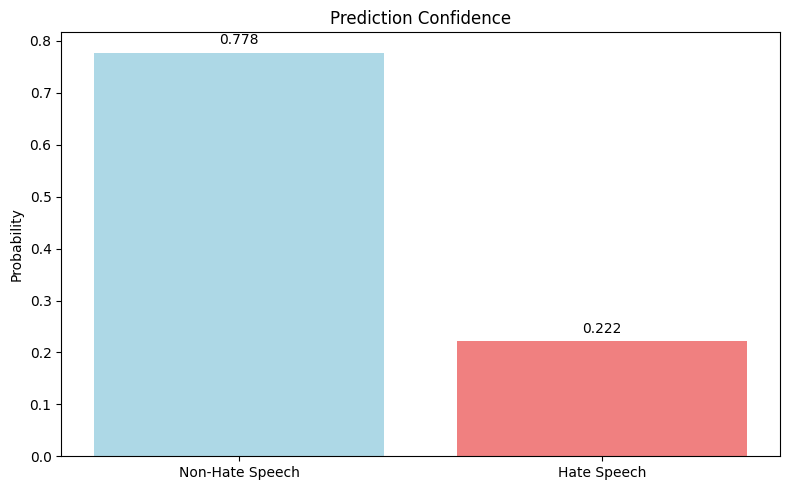

Expected: 0, Got: 0

Tagalog Example:
Text: Mahal ko ang aking pamilya at mga kaibigan. Sila ang nagbibigay ng kulay sa aking buhay.
Cleaned: mahal ko ang ake pamilya mga kaibigan. sila ang nagbibigay ng kulay sa ake buhay.
Prediction: 0 (Non-Hate Speech) (Confidence: 90.04%)


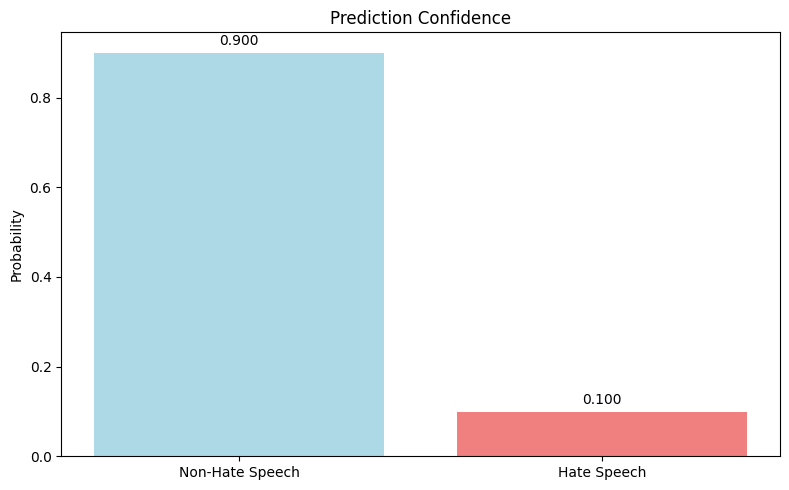

Expected: 0, Got: 0

Tagalog Example:
Text: Sana ngayong pasok... ay maalala mo parin ako.
Cleaned: sana ngayong pasok... ay maalala mo parin ako.
Prediction: 0 (Non-Hate Speech) (Confidence: 53.01%)


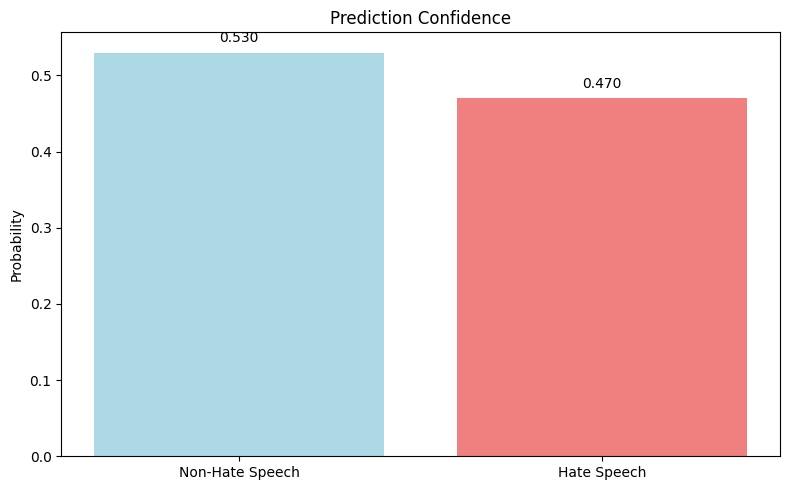

Expected: 0, Got: 0



In [193]:
print("="*60)
print("NON-HATE SPEECH EXAMPLES (SHOULD PREDICT 0):")
print("="*60)

# English
non_hate_english = "I love how diverse our community is and how everyone supports each other."
print("English Example:")
result = predict_text(non_hate_english)
print(f"Expected: 0, Got: {result}")
print()

# Tagalog
non_hate_tagalog = "Mahal ko ang aking pamilya at mga kaibigan. Sila ang nagbibigay ng kulay sa aking buhay."
print("Tagalog Example:")
result = predict_text(non_hate_tagalog)
print(f"Expected: 0, Got: {result}")
print()

# Tagalog
non_hate_tagalog = "Sana ngayong pasok... ay maalala mo parin ako."
print("Tagalog Example:")
result = predict_text(non_hate_tagalog)
print(f"Expected: 0, Got: {result}")
print()

24. Test the model by providing a hate speech input. The model should predict it as 1

HATE SPEECH EXAMPLES (SHOULD PREDICT 1):
English Example:
Text: What's up! my nigga!!, I'm your fucking neighborhood Gaylord Cocksucker. If you want your ass to stick-up your nose and straight-up to your candy ass, give me a hell yeah!
Cleaned: what' up! nigga!!, i'm fuck neighborhood gaylord cocksucker. if want ass stick-up nose straight-up candi ass, give hell yeah!
Prediction: 1 (Hate Speech) (Confidence: 91.04%)


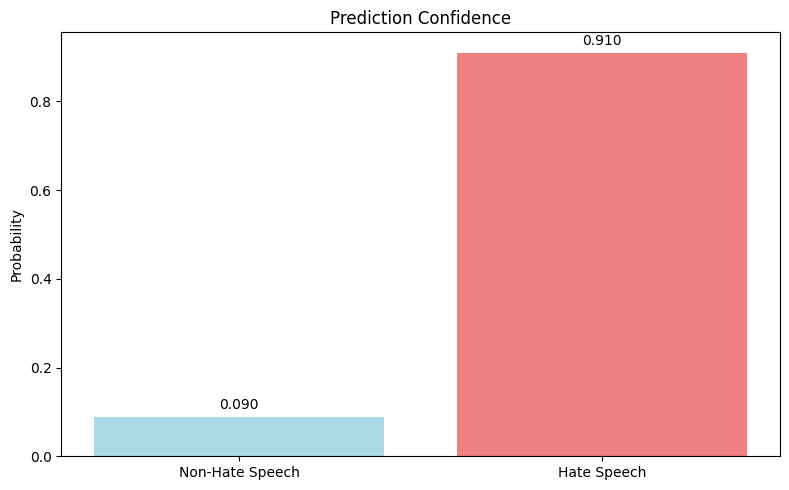

Expected: 1, Got: 1

Tagalog Example:
Text: Mga tanga at bobo kayong lahat. Dapat kayong mawala sa mundong ito. Tang inumin mo wag milo hahaha ulol!
Cleaned: mga tanga bobo kayong lahat. dapat kayong mawala sa mundong ito. tang inumin mo wag milo hahaha ulol!
Prediction: 1 (Hate Speech) (Confidence: 99.34%)


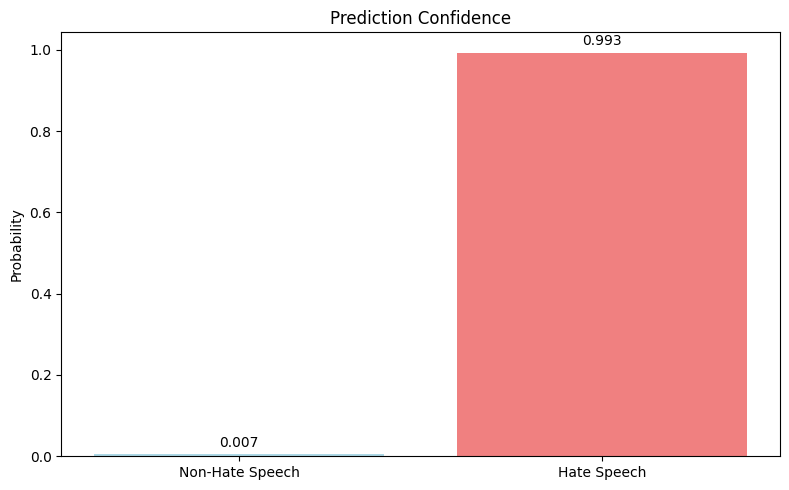

Expected: 1, Got: 1

Tagalog Example:
Text: Kung ang buko pie ay masarap, bakit mo piniling maging kabet?
Cleaned: kung ang buko pie ay masarap, bakit mo pinil mage kabet?
Prediction: 1 (Hate Speech) (Confidence: 79.89%)


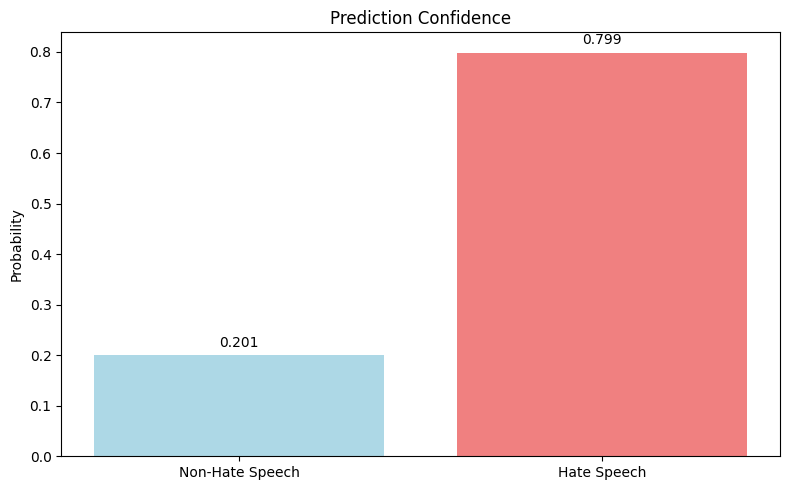

Expected: 1, Got: 1

Japanese Example:
Text: 調子はどうだい、ニガー？
Cleaned: 調子はどうだい、ニガー？
Prediction: 1 (Hate Speech) (Confidence: 50.49%)


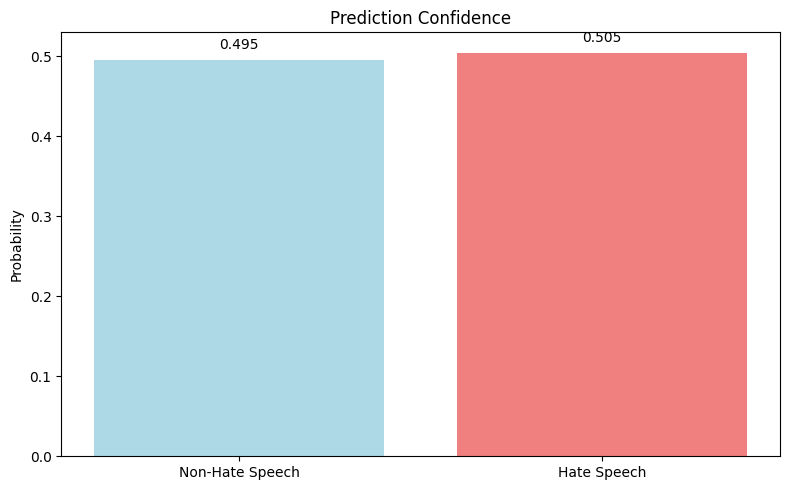

Expected: 1, Got: 1



In [196]:
print("="*60)
print("HATE SPEECH EXAMPLES (SHOULD PREDICT 1):")
print("="*60)

# English
hate_english = "What's up! my nigga!!, I'm your fucking neighborhood Gaylord Cocksucker. If you want your ass to stick-up your nose and straight-up to your candy ass, give me a hell yeah!"
print("English Example:")
result = predict_text(hate_english)
print(f"Expected: 1, Got: {result}")
print()

# Tagalog
hate_tagalog = "Mga tanga at bobo kayong lahat. Dapat kayong mawala sa mundong ito. Tang inumin mo wag milo hahaha ulol!"
print("Tagalog Example:")
result = predict_text(hate_tagalog)
print(f"Expected: 1, Got: {result}")
print()

# Tagalog
hate_tagalog = "Kung ang buko pie ay masarap, bakit mo piniling maging kabet?"
print("Tagalog Example:")
result = predict_text(hate_tagalog)
print(f"Expected: 1, Got: {result}")
print()

# Japanese
hate_japanese = "調子はどうだい、ニガー？"
print("Japanese Example:")
result = predict_text(hate_japanese)
print(f"Expected: 1, Got: {result}")
print()

#### I think the Japanese language looked balance on this one due to the language model are not primarily trained. The model was trained primarily on English/Filipino. Japanese text contains patterns that the model interprets as hate speech. In which hiragana and katakana was not able to be found on this dataset model 🤖 hahaha